In [4]:
import numpy as np
import glio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py as h5
import pandas as pd
import pymc
from NFW_model import *
from pymc.Matplot import plot

In [5]:
#This function uses glio to load the particle data from the Gadget files 
#Recieves the number of the snapshot to load and the directory where the snapshots are located
#Returns the particles properties and the time of the snapshot
def load_particles( n_snapshot, input_dir):
    file_name = input_dir + f'snapshot_{n_snapshot:03}'
    print( 'Loading file: ', file_name )
    file = glio.GadgetSnapshot( file_name )
    file.load()
    head = file.header
    box_size = head.BoxSize
    current_z = head.redshift
    print(f'Redshift: {current_z}')
    particle_type = 1                                   #Select dark matter particles (1) 
    positions = file.pos[particle_type]                 #Positions of dark matter particles
    mass = file.mass[particle_type]   * 1e10            #Mass of dark matter particles in Msolar
    positions_all = positions.transpose()                
    pos_z = positions_all[0]
    pos_y = positions_all[1]
    pos_x = positions_all[2]   
    return mass, pos_x, pos_y, pos_z, current_z

############################################################################################
def load_halo_particles(n_snapshot, input_dir ):
    import h5py as h5
    particles_file = input_dir + f'particles_{n_snapshot}.h5'
    particles = h5.File( particles_file, 'r' )
    p_x = particles['x'][...] * 1e3
    p_y = particles['y'][...] * 1e3
    p_z = particles['z'][...] * 1e3
    assigned_halo_id = particles['assigned_internal_haloid'][...]
    internal_halo_id = particles['internal_haloid'][...]
    external_halo_id = particles['external_haloid'][...]
    return p_x, p_y, p_z, assigned_halo_id, internal_halo_id, external_halo_id

############################################################################################
def get_particles_in_halo( halo_id, sub_halos=True ):
    #Load Particles with halo id
    p_x, p_y, p_z, halo_id_a, halo_id_i, halo_id_e = load_halo_particles( n_snapshot, input_dir )
    p_y = (p_y + 20e3 ) % Lbox

    indexs = np.where( halo_id_e == halo_id )
    pos_x = p_x[indexs]
    pos_y = p_y[indexs]
    pos_z = p_z[indexs]
    id_a = halo_id_a[indexs]
    id_i = halo_id_i[indexs]
    id_e = halo_id_e[indexs]
    if ( sub_halos == False ):
        #to exclude substructure, verify that the internal halo id is the same as the assigned internal halo id.
        indexs = np.where( id_i == id_a)
        pos_x = pos_x[indexs]
        pos_y = pos_y[indexs]
        pos_z = pos_z[indexs]
    return pos_x, pos_y, pos_z


############################################################################################
def plot_particles( depth, pos_x, pos_y, pos_z, output_directory):
    indxs = np.where( pos_z < depth)            #Select only the particles with z<depth
    pos_x_small = pos_x[indxs]                  #positions X of selected particles
    pos_y_small = pos_y[indxs]                  #positions Y of selected particles

    fig = plt.figure(0)
    fig.clf()
    fig.set_size_inches(20,20)
    plt.tight_layout()
    axis = plt.gca()
    axis.set_xlim(0, 100000)
    axis.set_ylim(0, 100000)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_visible(False)
    axis.scatter( pos_x_small, pos_y_small, s=0.002)   #Plot points for the particles 
    image_name = f'particles_{n_snapshot}.png'
    fig.savefig( output_directory + image_name,  pad_inches=0,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )


############################################################################################
def get_density( mass, pos_x, pos_y, pos_z, Lbox, nx, ny, nz ):
    dx = Lbox / nx
    dy = Lbox / ny
    dz = Lbox / nz
    dvol = dx * dy * dz
    density = np.zeros( [nx, ny, nz])

    indxs_x = ( pos_x / dx ).astype(np.int)
    indxs_y = ( pos_y / dy ).astype(np.int)
    indxs_z = ( pos_z / dz ).astype(np.int)

    total_particles = len( mass )

    for n_particle in range( total_particles ):
        indx_x = indxs_x[n_particle]
        indx_y = indxs_y[n_particle]
        indx_z = indxs_z[n_particle]
        part_mass = mass[n_particle]
        density[indx_z, indx_y, indx_x ] += part_mass

    density = density / dvol
    return density


############################################################################################
def plot_density( density, Lbox, output_directory ):
       
    density_proj = density.sum( axis=0)

    image_name = output_directory + f'density_{n_snapshot:03}.png'
    fig = plt.figure(0)
    fig.clf()
    fig.set_size_inches(20,20)
    plt.tight_layout()
    fig.set_size_inches(20,20)
    axis = plt.gca()
    axis.set_xlim(0, Lbox)
    axis.set_ylim(0, Lbox)
    image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    colorbar = fig.colorbar( image, cax=cax )
    colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.savefig(image_name,  pad_inches=0,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )

############################################################################################
def plot_particles_and_density( n_slices, Lbox, density, pos_x, pos_y, output_directory  ):
    depth = n_slices * dz

    indxs = np.where( pos_z < depth)           
    pos_x_small = pos_x[indxs]                 
    pos_y_small = pos_y[indxs]
    pos_y_small = Lbox - pos_y_small 

    dens = density[0:n_slices, :, :]

    fig, axis_list = plt.subplots(nrows=1, ncols=2, figsize=(40,20),  subplot_kw={'aspect': 1})
    plt.subplots_adjust( wspace=0.01)

    axis = axis_list[0]
    image = axis.scatter( pos_x_small, pos_y_small, s=0.002) 
    axis.set_xlim(0, Lbox)
    axis.set_ylim(0, Lbox)
    axis.set_title( "Dark Matter Particles", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)

    density_proj = dens.sum( axis=0)
    axis = axis_list[1]
    image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
    axis.set_title( "Dark Matter Density", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    colorbar = fig.colorbar(image, ax=axis_list, shrink=0.85, pad=0.01)
    colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
    image_name = f'part_dens_{n_snapshot}.png'
    fig.savefig( output_directory + image_name,  pad_inches=0.1,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )  
    

############################################################################################
def plot_halo_mass_function( h_mass, Lbox, output_directory, nBins=40):
    fig = plt.figure(0)
    ax = plt.gca() #Get curren axes
    mass_log = np.log10( h_mass )
    hist, bin_edges = np.histogram( mass_log, bins=nBins )
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # plt.plot(  bin_centers, np.log10(hist) )
    n_total = hist.sum()
    hist_cumul = ( n_total - hist.cumsum() ) / Lbox**3
    ax.plot(  bin_centers, np.log10(hist_cumul) )
    ax.set_xlabel(r'log Mass $[{\rm h^{-1} M_{\odot}}]$', fontsize=15 )
    ax.set_ylabel(r'log n(>M)  $[h^3{\rm Mpc^{-3}}]$', fontsize=15 )
    ax.set_title('Cumulative Halo Mass function', fontsize=15)
    fig.savefig( output_directory + 'halo_mass.function.png', bbox_inches='tight')

############################################################################################

def plot_particles_density_halos( n_snapshot, Lbox, nx, ny, nz, n_slices, input_dir, halos_dir, output_dir ):

    #Load Halos Catalog
    halos_file = halos_dir + f'halos_{n_snapshot:03}.ascii'
    print( "Loading Halos Catalog: " + halos_file )
    halos_data = pd.read_csv( halos_file, sep=' ')
    #Get Halos Positions
    x = halos_data['Z'].values * 1000
    y = halos_data['Y'].values * 1000
    z = halos_data['X'].values * 1000
    #Get Halos Radius
    r = halos_data['Rvir'].values
    #Get Halos Mass
    h_mass = halos_data['Mvir'].values
    y = (y + 20e3 ) %50e3

    #Load Particles data 
    mass, pos_x, pos_y, pos_z, current_z = load_particles( n_snapshot, input_dir)
    particle_mass = mass[0]
    pos_y = (pos_y + 20e3 ) % Lbox

    indxs = h_mass > 2e11
    x = x[indxs]
    y = y[indxs]
    z = z[indxs]
    r = r[indxs]
    nHalos = len( x )

    #Plot Halos Positions
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection

    dz = Lbox/nz    
    print( "Computing Density...")
    density = get_density( mass, pos_x, pos_y, pos_z, Lbox, nx, ny, nz )

    depth = n_slices * dz

    indxs = np.where( pos_z < depth)           
    pos_x_small = pos_x[indxs]                 
    pos_y_small = pos_y[indxs]
    pos_y_small = Lbox - pos_y_small 

    dens = density[0:n_slices, :, :]

    print( "Plotting...")
    fig, axis_list = plt.subplots(nrows=1, ncols=2, figsize=(40,20),  subplot_kw={'aspect': 1})
    plt.subplots_adjust( wspace=0.01)

    axis = axis_list[0]
    image = axis.scatter( pos_x_small, pos_y_small, s=0.0005) 
    circles = [ Circle( (x[i], Lbox - y[i]), r[i],) for i in range(nHalos) ]
    p = PatchCollection(circles, facecolors='none', edgecolors='k', linewidth=1.5, alpha=1 )
    axis.add_collection(p)
    axis.set_xlim(0, Lbox)
    axis.set_ylim(0, Lbox)
    axis.set_title( "Dark Matter Particles", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)

#     density_proj = (dens*dens).sum( axis=0) / dens.sum( axis=0)
    density_proj = (dens).sum( axis=0)  / nz
    axis = axis_list[1]
    image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
    axis.set_title( "Dark Matter Density", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    colorbar = fig.colorbar(image, ax=axis_list, shrink=0.85, pad=0.01)
    colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
    image_name = f'halos_part_density_{n_snapshot}.png'
    fig.savefig( output_dir + image_name,  pad_inches=0.1,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_dir+ image_name )  


############################################################################################
def get_halo_density( mass_index, n_snapshot, Lbox, nBins, input_dir, halos_dir, sub_halos=True):
    #Load Halos Catalog
    halos_file = halos_dir + f'halos_{n_snapshot:03}.ascii'
    halos_data = pd.read_csv( halos_file, sep=' ')
    #Get Halos Positions
    x = halos_data['Z'].values * 1000
    y = halos_data['Y'].values * 1000
    z = halos_data['X'].values * 1000
    #Get Halos Radius
    r = halos_data['Rvir'].values
    #Get Halos Mass
    h_mass = halos_data['Mvir'].values
    y = (y + 20e3 ) %50e3
    #Get halos IDs
    halo_ids = halos_data['ID'].values

    sorted_index = h_mass.argsort()[::-1]
    h_mass = h_mass[sorted_index]
    x = x[sorted_index]
    y = y[sorted_index]
    z = z[sorted_index]
    r = r[sorted_index]
    halo_ids = halo_ids[sorted_index]
    
    halo_mass = h_mass[mass_index]
    halo_x = x[mass_index]
    halo_y = y[mass_index]
    halo_z = z[mass_index]
    halo_r = r[mass_index]
    halo_id = halo_ids[mass_index]
    
    #Load Particles data 
    mass, pos_x, pos_y, pos_z, current_z = load_particles( n_snapshot, input_dir)
    particle_mass = mass[0]
    pos_y = (pos_y + 20e3 ) % Lbox
    
    if not sub_halos:
        #Get the particles that Rockstar Identified to the halo
        pos_x, pos_y, pos_z = get_particles_in_halo( halo_id, sub_halos=False )

    #Get the distances of all the particles to the center of the most massive halo
    dist = np.sqrt(  (pos_x - halo_x )**2 +
                     (pos_y - halo_y )**2 +
                     (pos_z - halo_z )**2    )

    #Get the indexes of the particles that are inside the halo
    in_halo_indxs = np.where( dist <= halo_r )

    #Select the distances of only the particles that are inside the halo
    dist_in = dist[in_halo_indxs]

    #Print the number of particles inside the halo
    n_in_halo = dist_in.size
    print( f'N particles in halo: {n_in_halo}' )

    #Sort the distances, closer to the center first and farest last
    dist_in.sort()

    #Now we divide the radius of the halo in to bins 
    #and count how many particles are in each bin
    n_bins =  nBins

    #Divide the raidus of the halo, the split is uniform in logarithmic scale
    #Get the egdes of the bins
    dist_first_particle = np.log10(dist_in[0]) 
    dist_last_particle  = np.log10(dist_in[-1])
    #Get the array with the egdes of the bins
    edges = np.logspace( dist_first_particle, dist_last_particle, n_bins+1 )

    #Now we use a histogram to count how mani particles are in each bin
    #We pass the edges to the histogram function
    counts, bin_edges = np.histogram( dist_in, bins=edges )
    #Now we find the centers of the bins using the average of the inner and outer radius
    bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2


    #Now we use the edges of each bin to get the volume of each cell
    shells_volume = [] #List in wich we will save the values of the volume of the shells
    for i in range(n_bins):
        edge_left = edges[i] #inner radius of the shell
        edge_right = edges[i+1] #outer radius of the shell
        volume = 4 * np.pi / 3 * ( edge_right**3 - edge_left**3) #Volume of the shell
        shells_volume.append(volume) #Append the volume of the shell to the list of volumes

    #Convert the list of volumes to an array, this allow us to do math operations with the array
    shells_volume = np.array( shells_volume ) 


    #Now we have the number of particles on each bin (shell) and the volume of each cell
    #To get the density we divide the mass in each cell by the volume of each cell
    mass_in_shell = counts * particle_mass
    density =  mass_in_shell / shells_volume
    error = density / np.sqrt(counts)
    return bin_centers, density, error
############################################################################################

def NFW_density_profile( r, rho_0, r_s ):
    return rho_0 / ( (r/r_s)*(1 + r/r_s)**2 )

############################################################################################

def fit_NFW_density_profile( bin_centers, density, density_error, nIter ):
    nBurn = nIter / 10
    nThin = 10

    r_data = bin_centers
    data = density
    dataError = density_error

    model = dens_model_NFW( r_data, data, dataError )
    densMDL = pymc.MCMC( model )
    densMDL.sample( iter=nIter, burn=nBurn, thin=nThin )
    modelResults = getModelResults_dens( r_data, data, densMDL )
    #Extract  results from mcmcm model
    r0_mean, r0_max, r0_min = modelResults['r0']['mean'], modelResults['r0']['max'], modelResults['r0']['min']
    rho0_mean, rho0_max, rho0_min = modelResults['rho0']['mean'], modelResults['rho0']['max'], modelResults['rho0']['min']
    return rho0_mean, r0_mean, densMDL
############################################################################################


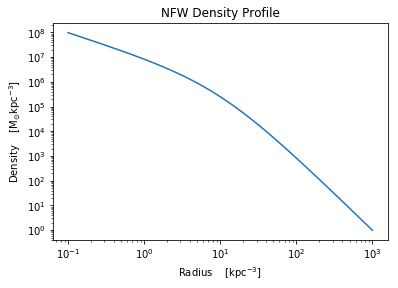

In [6]:
#Plot NFW density profile
#NFW density profile
rho_0 = 1e6
r_0 =  10
r = np.linspace( 0.1, 1000, 10000)
density = NFW_density_profile( r, rho_0, r_0 )
plt.loglog( r,  density)
plt.xlabel(r'Radius    $[\mathrm{kpc^{-3}}]$')
plt.ylabel(r'Density    $[ \mathrm{ M_{\odot}  kpc^{-3}}]$')
plt.title("NFW Density Profile")
plt.savefig('nfw_dens.png')

Loading file:  /data/jovians/ay9_2019/dark_matter_simulations/data/256_dm/snapshot_100
Redshift: 0.0
N particles in halo: 871204
 [-----------------100%-----------------] 200000 of 200000 complete in 35.4 secPlotting rho0
Plotting r0


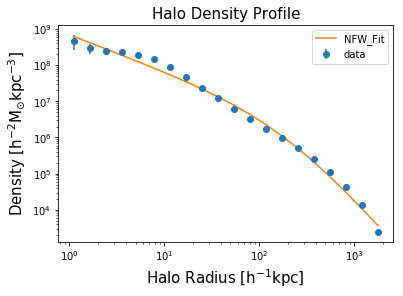

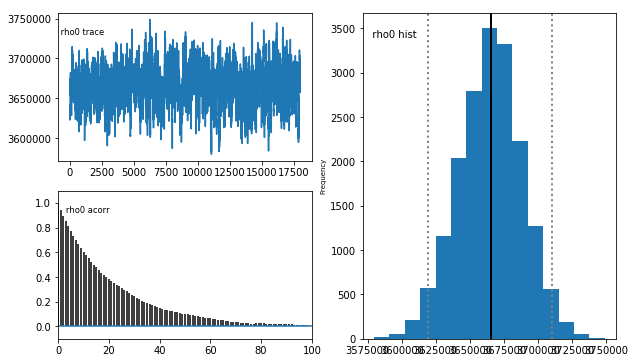

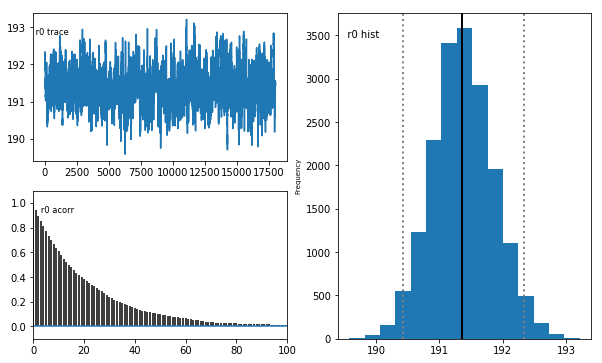

In [7]:
# Get The Halo Density Profile
data_dir = '/data/jovians/ay9_2019/dark_matter_simulations/data/'
input_dir = data_dir + '256_dm/'
halos_dir = data_dir + 'halo_catalogs_256/'
output_dir = 'images/particles_density/'

n_snapshot = 100
Lbox = 50e3

#How many bins to divide the halo radius
nBins = 20

#Get the halo density
mass_index = 0
bin_centers, halo_density, density_error = get_halo_density( mass_index, n_snapshot, 
                                     Lbox, nBins, input_dir, halos_dir, sub_halos=False)

#Fit using MCMC
nIter = 2e5
rho0_mean, r0_mean, dens_model = fit_NFW_density_profile( bin_centers, halo_density, density_error, nIter )

#Plot the density data and fitted profile
fig = plt.figure(0)
ax = plt.gca() #Get curren axes
ax.errorbar(  bin_centers, halo_density, yerr=density_error, fmt='o',  label='data')
ax.plot(  bin_centers, NFW_density_profile(bin_centers, rho0_mean, r0_mean  ), label="NFW_Fit" )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'Density $[{\rm h^{-2} M_{\odot}  kpc^{-3}}]$', fontsize=15 )
ax.set_xlabel(r'Halo Radius $[\rm h^{-1} kpc]$', fontsize=15 )
ax.set_title('Halo Density Profile', fontsize=15)
ax.legend()

#Plot the distribution of the fitted parameters (rho_0 and r_0 )
plot(dens_model)


Loading Halos Catalog: /data/jovians/ay9_2019/dark_matter_simulations/data/halo_catalogs_256/halos_000.ascii
Loading file:  /data/jovians/ay9_2019/dark_matter_simulations/data/256_dm/snapshot_000
Redshift: 100.00000101
Computing Density...
Plotting...
Saved image:  images/particles_density/halos_part_density_0.png


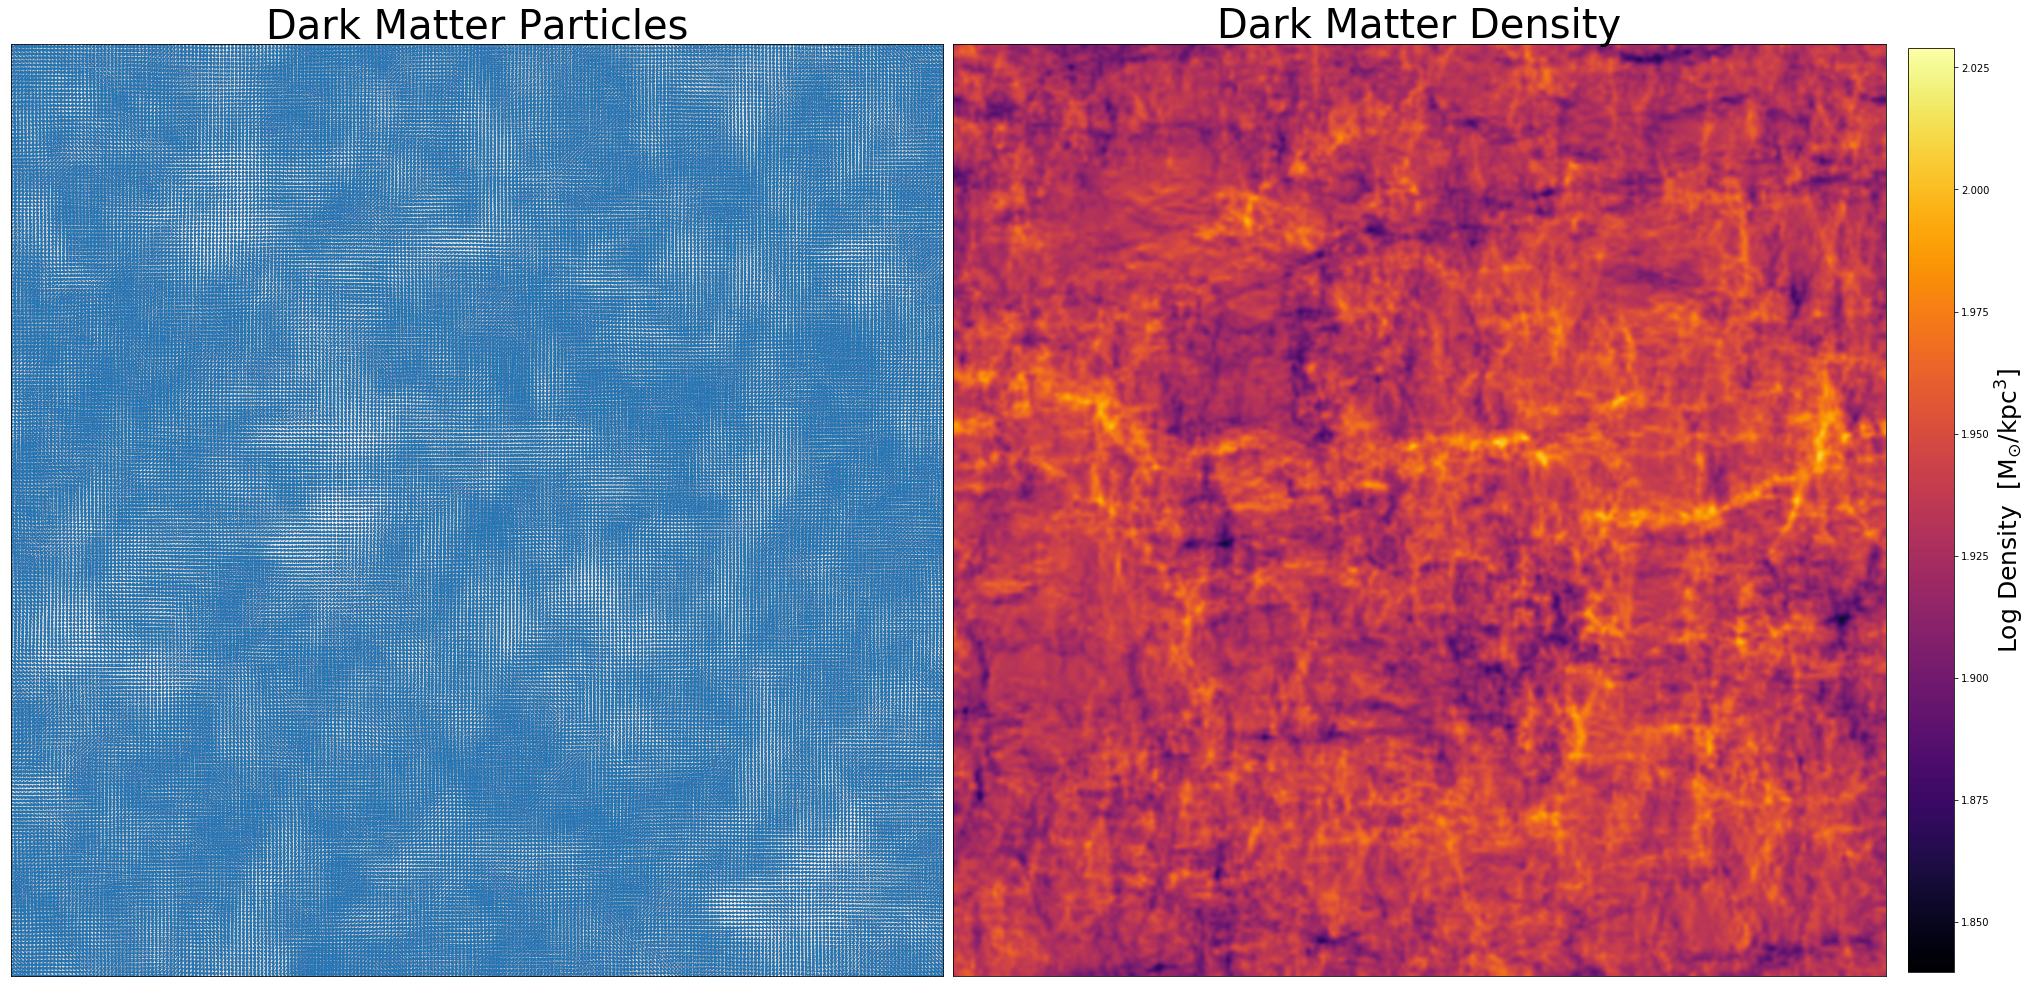

In [10]:
#Plot Particles and Density with Halos
data_dir = '/data/jovians/ay9_2019/dark_matter_simulations/data/'
input_dir = data_dir + '256_dm/'
halos_dir = data_dir + 'halo_catalogs_256/'
output_dir = 'images/particles_density/'

n_snapshot = 0

n_slices = 256
nx = 256
ny = 256
nz = 256

Lbox = 50e3

plot_particles_density_halos( n_snapshot, Lbox, nx, ny, nz, n_slices, input_dir, halos_dir, output_dir )


In [9]:
# # Load halo catalog and plot Halo Mass Function
# data_dir = '/data/jovians/ay9_2019/dark_matter_simulations/data/'
# halos_dir = data_dir + 'halo_catalogs_128/'


# halos_file = halos_dir + f'halos_{n_snapshot:03}.ascii'

# Lbox = 100
# n_snapshot = 200

# #Load Halo catalog
# halos_data = pd.read_csv( halos_file, sep=' ')

# #Get Halos Data
# halos_mass = halos_data['mvir']
# plot_halo_mass_function( halos_mass, Lbox, output_directory, nBins=40)

